# 4. Data processing and cleaning

Preprocessing (resizing, normalization, etc.) standardizes the input data so that all images have a consistent size and pixel range. This consistency is crucial because it ensures that any further operations—like data augmentation or dimensionality reduction—work on a uniform set of inputs. Once the images are preprocessed, I can apply data augmentation to artificially increase the dataset’s variability (e.g., rotations, shifts, flips), which helps improve the model’s ability to generalize. Finally, if I need to further reduce the computational burden, I can apply dimensionality reduction (for example, using a pre-trained model for feature extraction or an autoencoder) on these preprocessed (and possibly augmented) images. Moreover, we can implement different ways to clean our dataset, like removing duplicates from our folder.

## Data Preprocessing
Standardizes images (e.g., resizing to 150×150 and normalizing pixel values) so that all images are consistent.

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define the new training directory in the copied dataset
new_train_dir = os.path.join('intel_dataset_copy', 'seg_train', 'seg_train')

# Create a data generator for preprocessing (rescaling)
preprocess_gen = ImageDataGenerator(rescale=1./255)

# This generator loads preprocessed images from the copied dataset
train_preprocess_generator = preprocess_gen.flow_from_directory(
    new_train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 14034 images belonging to 6 classes.


Ensure images are oriented correctly and converted to RGB format

In [3]:
import numpy as np
from PIL import Image, ImageOps
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def custom_preprocessing_function(img):
    """
    Convert the input image to a PIL image, correct orientation using EXIF data,
    and ensure it's in RGB format, then convert back to a NumPy array.
    """
    # The generator passes images as numpy arrays in [0,255] range
    pil_img = Image.fromarray(img.astype('uint8'), 'RGB')
    # Correct orientation if EXIF data is present
    pil_img = ImageOps.exif_transpose(pil_img)
    # Return as numpy array
    return np.array(pil_img)

# Create a data generator with your augmentation parameters and the custom preprocessing function
augment_gen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=custom_preprocessing_function,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Use the copied dataset directory
new_train_dir = 'intel_dataset_copy/seg_train/seg_train'

train_augment_generator = augment_gen.flow_from_directory(
    new_train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 14034 images belonging to 6 classes.


## Data Augmentation
Increases dataset variability through random transformations, which helps your model learn robust features and generalize better.<br>
Since there are enough datasets, we will not be using transfer learning.

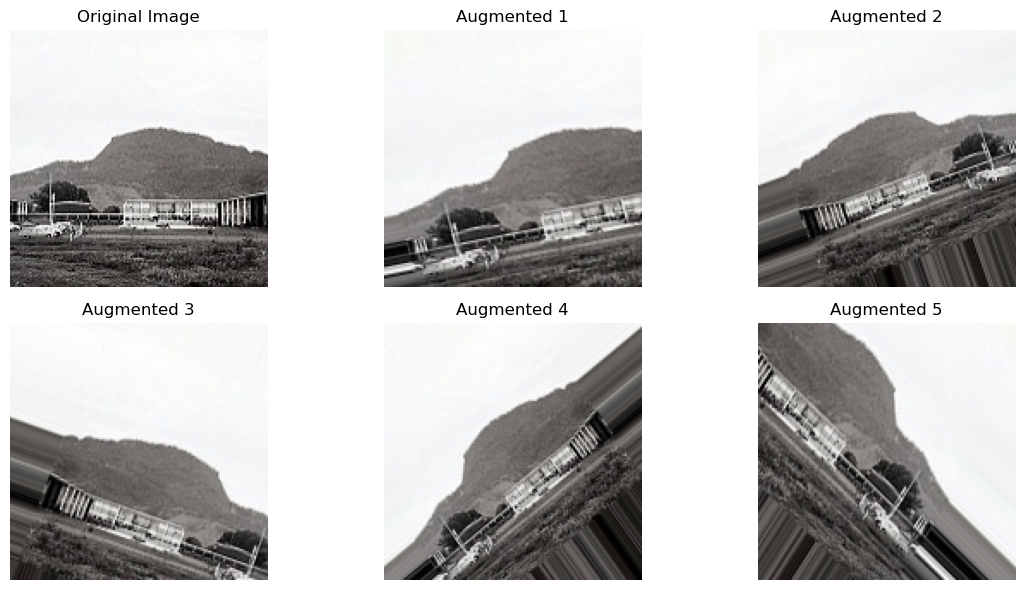

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Define the augmentation generator with your parameters
augment_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Define the copied training directory (adjust class as needed)
new_train_dir = os.path.join('intel_dataset_copy', 'seg_train', 'seg_train')
sample_class = 'buildings'  # Choose the class to sample from
sample_dir = os.path.join(new_train_dir, sample_class)

# Get a sample image file from the chosen class
img_files = sorted([f for f in os.listdir(sample_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
if img_files:
    img_path = os.path.join(sample_dir, img_files[0])
    
    # Load and display the original image (resized to 150x150 for consistency)
    original_img = load_img(img_path, target_size=(150, 150))
    original_img_array = img_to_array(original_img)
    
    # Prepare the image for augmentation by adding a batch dimension
    sample = np.expand_dims(original_img_array, axis=0)
    
    # Create an iterator that applies augmentation
    aug_iter = augment_gen.flow(sample, batch_size=1)
    
    # Plot original and a few augmented images
    plt.figure(figsize=(12, 6))
    
    # Display the original image in the first subplot
    plt.subplot(2, 3, 1)
    plt.imshow(original_img)
    plt.title("Original Image")
    plt.axis('off')
    
    # Generate and display 5 augmented versions
    for i in range(2, 7):
        batch = next(aug_iter)
        aug_img = batch[0]  # Get the augmented image from the batch
        plt.subplot(2, 3, i)
        plt.imshow(aug_img)
        plt.title(f"Augmented {i-1}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print(f"No images found in {sample_dir}.")

## Dimensionality Reduction
I can reduce the input dimensionality to lower computational costs. Using a pre-trained model like VGG16 for dimensionality reduction computes the feature representations on the fly during prediction. The VGG16 base converts a 150×150×3 image into a lower-dimensional feature tensor (for example, something like 4×4×512, depending on the architecture and input size). These features represent a compressed version of the original image, capturing its most salient information.

In [7]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load VGG16 pre-trained on ImageNet, excluding its top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add new classifier layers on top of the base model
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
# Assume num_classes is defined (e.g., using len(os.listdir(new_train_dir)) if folder names match classes)
num_classes = len([d for d in os.listdir(new_train_dir) if os.path.isdir(os.path.join(new_train_dir, d))])
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 150, 150, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 150, 150, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 150, 150, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 75, 75, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 37, 37, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 18, 18, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 18, 18, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 9, 9, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 9, 9, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,764,166 (60.14 MB)

 Trainable params: 1,049,478 (4.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


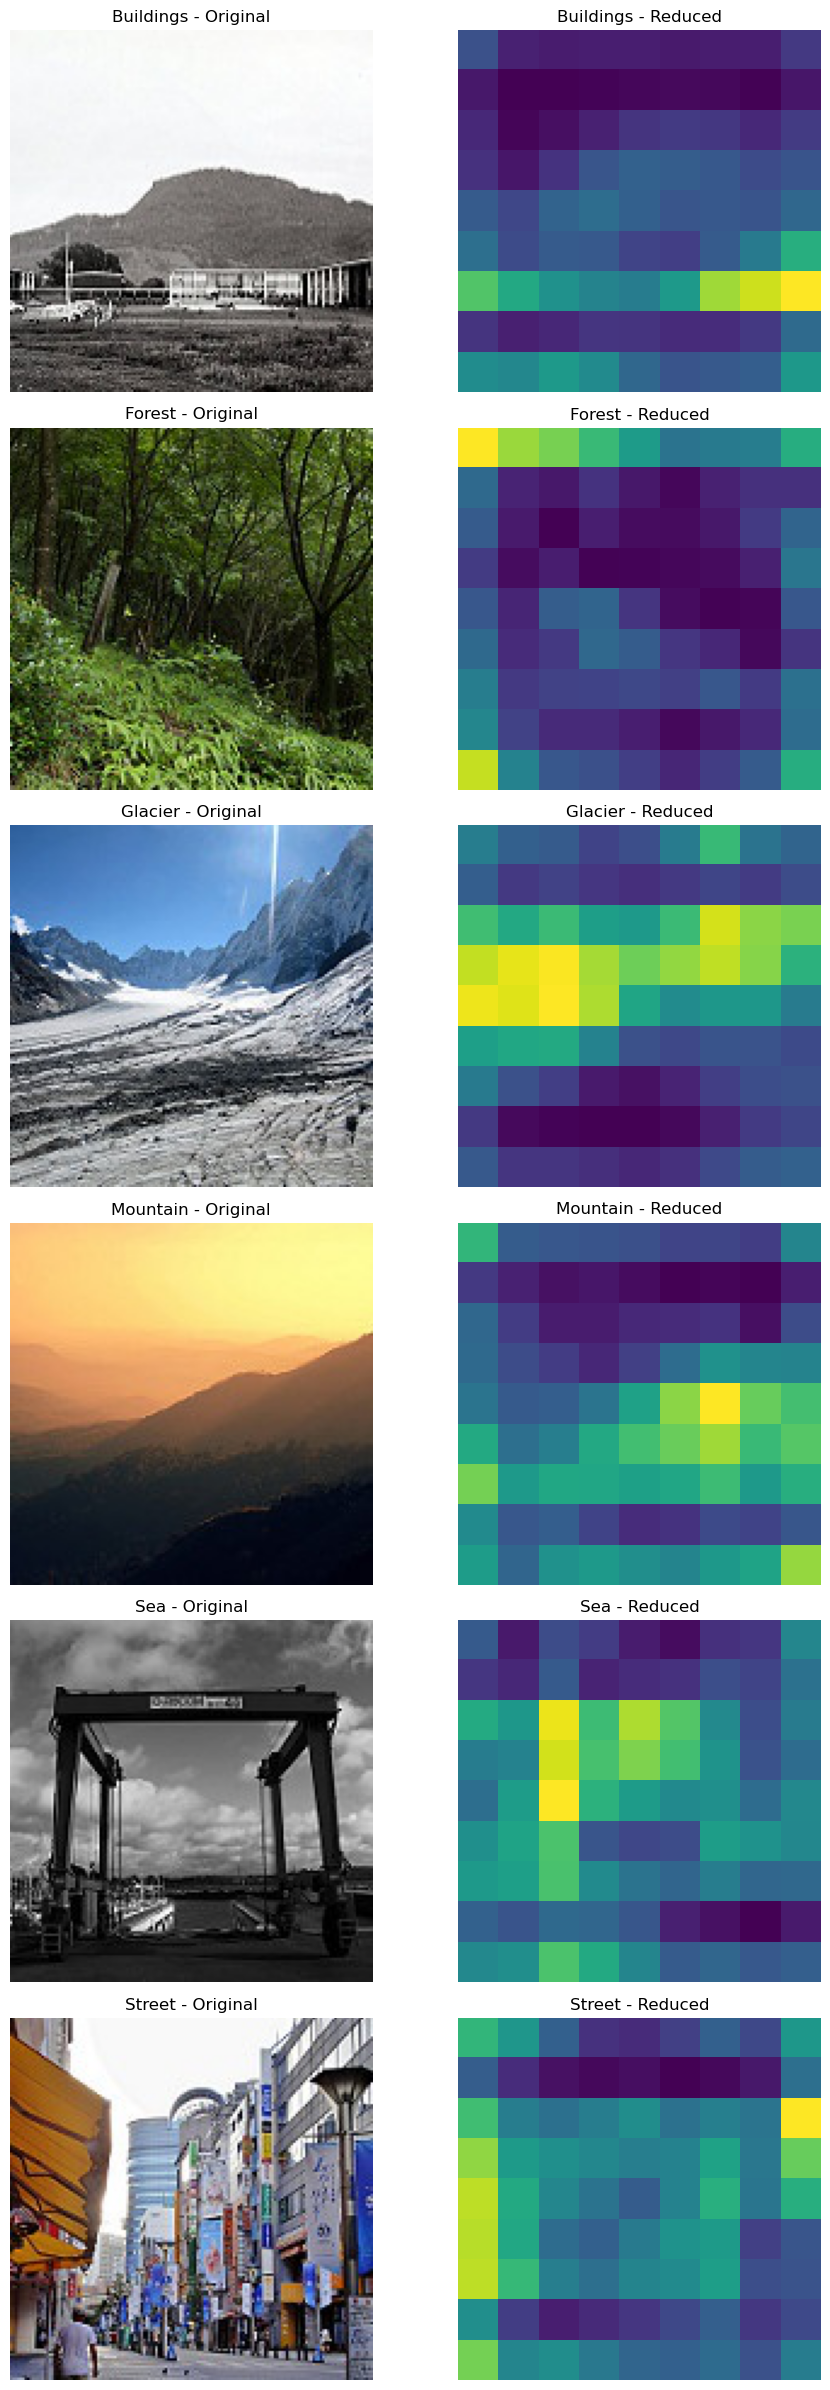

In [9]:
# Viewing a side by side comparison of the image and the reduced dimensionality image.

import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model

# Define new training directory from the copied dataset
new_train_dir = os.path.join('intel_dataset_copy', 'seg_train', 'seg_train')

# Load VGG16 pre-trained on ImageNet (exclude the top classification layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))
for layer in base_model.layers:
    layer.trainable = False

# Create a feature extractor model that outputs from a deep layer, e.g., 'block5_conv3'
feature_extractor = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_conv3').output)

# Get a sorted list of classes
classes = sorted([d for d in os.listdir(new_train_dir) if os.path.isdir(os.path.join(new_train_dir, d))])

# Create a figure with two columns: one for original and one for reduced image, one row per class
num_classes = len(classes)
plt.figure(figsize=(10, 4 * num_classes))

for idx, cls in enumerate(classes):
    cls_path = os.path.join(new_train_dir, cls)
    # Get a sorted list of images from the class folder
    img_files = sorted([f for f in os.listdir(cls_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
    if not img_files:
        continue
    # Use the first image as a sample
    sample_img_path = os.path.join(cls_path, img_files[0])
    
    # Load the original image (resized to 150x150)
    orig_img = image.load_img(sample_img_path, target_size=(150,150))
    img_array = image.img_to_array(orig_img)
    # Prepare the image for VGG16
    img_array_expanded = np.expand_dims(img_array, axis=0)
    img_preprocessed = preprocess_input(img_array_expanded)
    
    # Get the feature map from the feature extractor
    features = feature_extractor.predict(img_preprocessed)[0]  # shape: (h, w, channels)
    # Average across channels to get a 2D representation
    features_mean = np.mean(features, axis=-1)
    
    # Plot the original image on the left
    plt.subplot(num_classes, 2, idx*2 + 1)
    plt.imshow(orig_img)
    plt.title(f"{cls.capitalize()} - Original")
    plt.axis('off')
    
    # Plot the reduced feature map on the right
    plt.subplot(num_classes, 2, idx*2 + 2)
    plt.imshow(features_mean, cmap='viridis')
    plt.title(f"{cls.capitalize()} - Reduced")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Removal of duplicate images

We do not want to overtrain our model on a particular image so we must remove any duplicated images from our dataset to ensure there's no overfitting on a specific image

In [11]:
import os
import hashlib

def remove_duplicate_images(directory):
    """Recursively removes duplicate images from the directory based on MD5 hash."""
    hashes = {}
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(root, file)
                try:
                    with open(file_path, 'rb') as f:
                        file_hash = hashlib.md5(f.read()).hexdigest()
                    if file_hash in hashes:
                        print(f"Duplicate found: {file_path} (duplicate of {hashes[file_hash]})")
                        os.remove(file_path)
                    else:
                        hashes[file_hash] = file_path
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

# Define the copied dataset folder (this example removes duplicates in all subfolders)
copy_dataset_dir = 'intel_dataset_copy'
remove_duplicate_images(copy_dataset_dir)

Duplicate found: intel_dataset_copy/seg_train/seg_train/forest/8688.jpg (duplicate of intel_dataset_copy/seg_train/seg_train/forest/8689.jpg)
Duplicate found: intel_dataset_copy/seg_train/seg_train/forest/15657.jpg (duplicate of intel_dataset_copy/seg_train/seg_train/forest/18807.jpg)
Duplicate found: intel_dataset_copy/seg_train/seg_train/buildings/4634.jpg (duplicate of intel_dataset_copy/seg_test/seg_test/street/21170.jpg)
Duplicate found: intel_dataset_copy/seg_train/seg_train/street/7293.jpg (duplicate of intel_dataset_copy/seg_train/seg_train/buildings/9769.jpg)
Duplicate found: intel_dataset_copy/seg_train/seg_train/street/1495.jpg (duplicate of intel_dataset_copy/seg_train/seg_train/buildings/4551.jpg)
Duplicate found: intel_dataset_copy/seg_train/seg_train/street/2764.jpg (duplicate of intel_dataset_copy/seg_train/seg_train/buildings/5069.jpg)
Duplicate found: intel_dataset_copy/seg_train/seg_train/street/3492.jpg (duplicate of intel_dataset_copy/seg_train/seg_train/street/373

## Check for corrupted or unreadable images

I can scan your dataset for images that cannot be opened (or that raise errors during processing) and remove them. This ensures my data pipeline isn’t interrupted during training.

In [13]:
import os
from PIL import Image

def remove_corrupted_images(directory):
    """
    Scans through the directory recursively and removes images that are corrupted or cannot be opened.
    """
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(root, file)
                try:
                    # Try to open and load the image
                    with Image.open(file_path) as img:
                        img.verify()  # Verify that it is, in fact, an image
                except Exception as e:
                    print(f"Corrupted image found and removed: {file_path}. Error: {e}")
                    os.remove(file_path)

# Define the copied dataset directory (this will scan all subfolders)
copied_dataset_dir = 'intel_dataset_copy'
remove_corrupted_images(copied_dataset_dir)